In [33]:
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import pm4py
from pm4py.statistics.traces.log import case_statistics
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness


In [34]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("Username", "Password"))
session = driver.session()

In [ ]:
def calculate_activity_duration_stats_mod(log):
    duration_stats = {}
    for activity in log['new_activity'].unique():
        activity_log = log[log['new_activity'] == activity]
        
        start_times = activity_log.groupby('case:concept:name')['time:timestamp'].min()
        end_times = activity_log.groupby('case:concept:name')['time:timestamp'].max()
        
        durations = (end_times - start_times).dt.total_seconds() / 60 
        
        if activity == 'assembly': 
            activity_log = log[
            ((log['new_activity'] == 'washing') & (log['lifecycle'] == 'complete')) |
            ((log['new_activity'] == 'sterilizing') & (log['lifecycle'] == 'start'))
        ]        
            start_times = activity_log.groupby('case:concept:name')['time:timestamp'].min()
        
            end_times = activity_log.groupby('case:concept:name')['time:timestamp'].max()
            durations = (end_times - start_times).dt.total_seconds() / 60 
        
            mean_duration = durations.mean()
            std_duration = durations.std()
            
            duration_stats[activity] = {
            'Mean Duration (minutes)': mean_duration,
            'Std Duration (minutes)': std_duration
            }

            continue
        
        mean_duration = durations.mean()
        std_duration = durations.std()
        
        duration_stats[activity] = {
            'Mean Duration (minutes)': mean_duration,
            'Std Duration (minutes)': std_duration
        }
        
    return pd.DataFrame(duration_stats).T

In [ ]:
def calculate_activity_duration_stats(log):
    duration_stats = {}
    for activity in log['new_activity'].unique():
        activity_log = log[log['new_activity'] == activity]
        
        start_times = activity_log.groupby('case:concept:name')['time:timestamp'].min()
        end_times = activity_log.groupby('case:concept:name')['time:timestamp'].max()
        
        durations = (end_times - start_times).dt.total_seconds() / 60  
        mean_duration = durations.mean()
        std_duration = durations.std()
        
        duration_stats[activity] = {
            'Mean Duration (minutes)': mean_duration,
            'Std Duration (minutes)': std_duration
        }
        
    return pd.DataFrame(duration_stats).T

In [35]:
query = '''match (r:Run {EntityType: 'Kit'}) <- [:CORR] - (e:Event)
where not e.KitID contains "CONT"
return e.Usuario, e.timestamp, e.Activity, e.KitID, e.NS, e.Código, r.CaseID'''

result = session.run(query)
data = result.data()

df = pd.DataFrame(data)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df['date'] = df['e.timestamp'].dt.date
df['day_of_week'] = df['e.timestamp'].dt.dayofweek

weekdays_df = df[df['day_of_week'] < 5]
weekends_df = df[df['day_of_week'] >= 5]

weekdays_df = weekdays_df.drop(columns=['day_of_week'])
weekends_df = weekends_df.drop(columns=['day_of_week'])

weekends_df = weekends_df.append(weekdays_df[pd.to_datetime(weekdays_df['date']) == pd.to_datetime('2022-01-06', format='%Y-%m-%d')], ignore_index=True)
weekdays_df = weekdays_df[pd.to_datetime(weekdays_df['date']) != pd.to_datetime('2022-01-06', format='%Y-%m-%d')]

event_log = pm4py.format_dataframe(weekends_df, case_id='r.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
event_log = pm4py.convert_to_event_log(event_log)

total_event_log = pm4py.format_dataframe(df, case_id='r.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
total_event_log = pm4py.convert_to_event_log(total_event_log)

In [37]:

log1 = pm4py.read_xes('/Users/abdalrhman/Documents/bdma-thesis/python/Simulation/output_24_08_21_11_31_07_524/Croma_Process_2-7.xes')
sdf = xes_converter.apply(log1, variant=xes_converter.Variants.TO_DATA_FRAME)
sdf['time:timestamp'] = pd.to_datetime(sdf['time:timestamp'], utc=True)
sdf['date'] = sdf['time:timestamp'].dt.date
sdf.head()

parsing log, completed traces :: 100%|██████████| 905/905 [00:00<00:00, 1463.71it/s]


,concept:name,lifecycle:transition,time:timestamp,case:concept:name,org:resource,date
0,Contaminated Kits,start,2022-02-28 23:00:00+00:00,1,NaN,2022-02-28
1,Contaminated Kits,complete,2022-02-28 23:00:00+00:00,1,NaN,2022-02-28
2,Entrada Material Sucio,start,2022-03-01 06:00:00+00:00,1,Usuario_CLE,2022-03-01
3,Entrada Material Sucio,complete,2022-03-01 06:17:50+00:00,1,Usuario_CLE,2022-03-01
4,Cargado en carro L+D,start,2022-03-01 06:33:48+00:00,1,Usuario_CLE,2022-03-01


In [38]:
log2 = xes_converter.apply(total_event_log, variant=xes_converter.Variants.TO_DATA_FRAME)
shared_dates = list(set(sdf['date'].unique()) & set(log2['date'].dt.date.unique()))
filtered_el = log2[log2['date'].dt.date.isin(shared_dates)]
filtered_sdf = sdf[sdf['date'].isin(shared_dates)]

                                 Log 1 Frequency  Log 2 Frequency  \
CONTENE                                      516                0   
Carga L+D iniciada                          1810              954   
Carga L+D liberada                          1810              899   
Carga de esterilizador liberada            10892             2754   
Cargado en carro L+D                        1810              951   
Carros                                        56                0   
Comisionado                                    0              488   
Composición de cargas                      10892             2809   
Contaminated Kits                           1810                0   
Contenedores                                   2                0   
Delicado                                      12                0   
Entrada Material Sucio                      1810              786   
GOMAS                                        154                0   
INTRUM                            

<AxesSubplot:title={'center':'Activity Frequency Comparison'}>

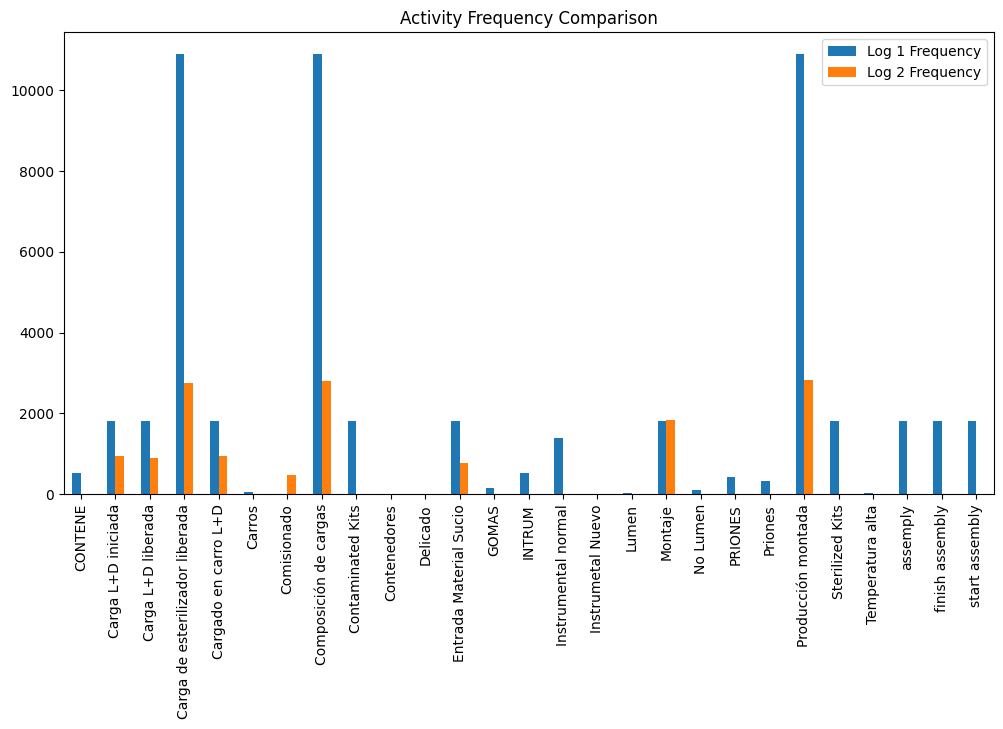

In [40]:
activity_freq_log1 = filtered_sdf['concept:name'].value_counts().sort_index()
activity_freq_log2 = filtered_el['concept:name'].value_counts().sort_index()

all_activities = activity_freq_log1.index.union(activity_freq_log2.index)
activity_freq_log1 = activity_freq_log1.reindex(all_activities, fill_value=0)
activity_freq_log2 = activity_freq_log2.reindex(all_activities, fill_value=0)

absolute_diff = (activity_freq_log1 - activity_freq_log2).abs()

comparison_df = pd.DataFrame({
    'Log 1 Frequency': activity_freq_log1,
    'Log 2 Frequency': activity_freq_log2,
    'Absolute Difference': absolute_diff
})

print(comparison_df)

comparison_df[['Log 1 Frequency', 'Log 2 Frequency']].plot(kind='bar', figsize=(12, 6), title='Activity Frequency Comparison')


                                 Generated Data Relative Frequency  \
CONTENE                                                   0.009486   
Carga L+D iniciada                                        0.033275   
Carga L+D liberada                                        0.033275   
Carga de esterilizador liberada                           0.200235   
Cargado en carro L+D                                      0.033275   
Carros                                                    0.001029   
Comisionado                                               0.000000   
Composición de cargas                                     0.200235   
Contaminated Kits                                         0.033275   
Contenedores                                              0.000037   
Delicado                                                  0.000221   
Entrada Material Sucio                                    0.033275   
GOMAS                                                     0.002831   
INTRUM              

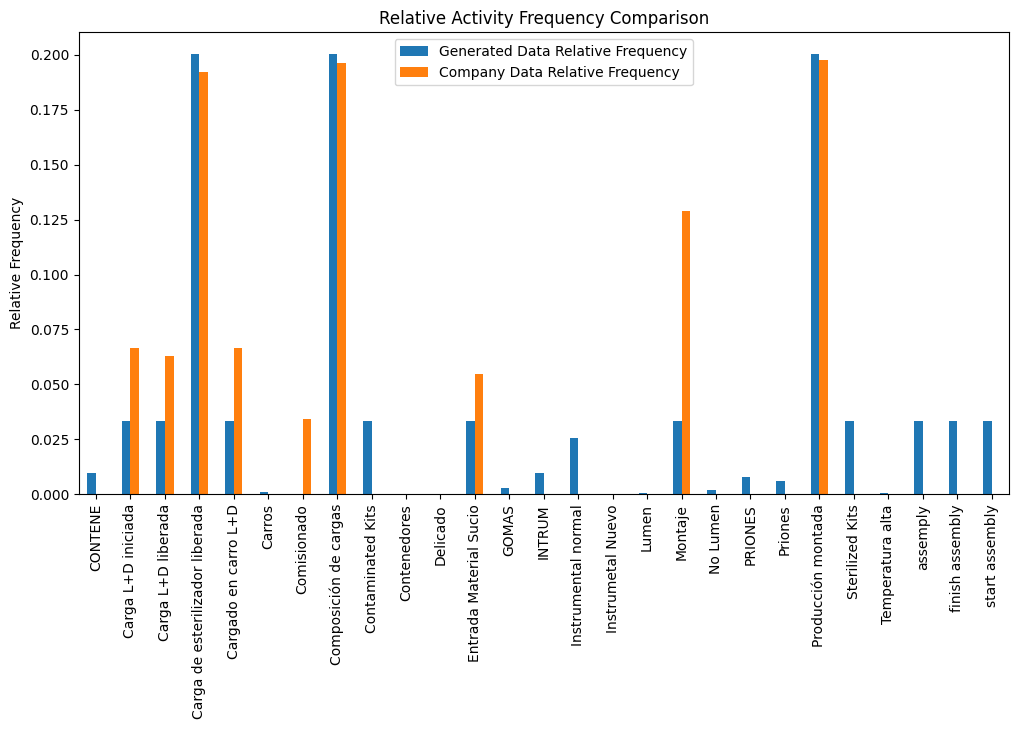

In [42]:
log1 = filtered_sdf.copy()
log2 = filtered_el.copy()

activity_freq_log1 = log1['concept:name'].value_counts()
activity_freq_log2 = log2['concept:name'].value_counts()

total_activities_log1 = activity_freq_log1.sum()
total_activities_log2 = activity_freq_log2.sum()

relative_freq_log1 = activity_freq_log1 / total_activities_log1
relative_freq_log2 = activity_freq_log2 / total_activities_log2

all_activities = relative_freq_log1.index.union(relative_freq_log2.index)

relative_freq_log1 = relative_freq_log1.reindex(all_activities, fill_value=0)
relative_freq_log2 = relative_freq_log2.reindex(all_activities, fill_value=0)

relative_diff = (relative_freq_log1 - relative_freq_log2).abs()

comparison_df = pd.DataFrame({
    'Generated Data Relative Frequency': relative_freq_log1,
    'Company Data Relative Frequency': relative_freq_log2,
    'Relative Difference': relative_diff
})
print(comparison_df)
comparison_df[['Generated Data Relative Frequency', 'Company Data Relative Frequency']].plot(kind='bar', figsize=(12, 6), title='Relative Activity Frequency Comparison')
plt.ylabel('Relative Frequency')
plt.show()


                           Log 1 Arrival Rate  Log 2 Arrival Rate  \
Arrival Time                                                        
2022-02-28 00:00:00+00:00                  13                 544   
2022-03-01 00:00:00+00:00                 294                 281   
2022-03-02 00:00:00+00:00                 292                 295   
2022-03-03 00:00:00+00:00                 292                 269   
2022-03-04 00:00:00+00:00                  14                 302   

                           Absolute Difference  
Arrival Time                                    
2022-02-28 00:00:00+00:00                  531  
2022-03-01 00:00:00+00:00                   13  
2022-03-02 00:00:00+00:00                    3  
2022-03-03 00:00:00+00:00                   23  
2022-03-04 00:00:00+00:00                  288  


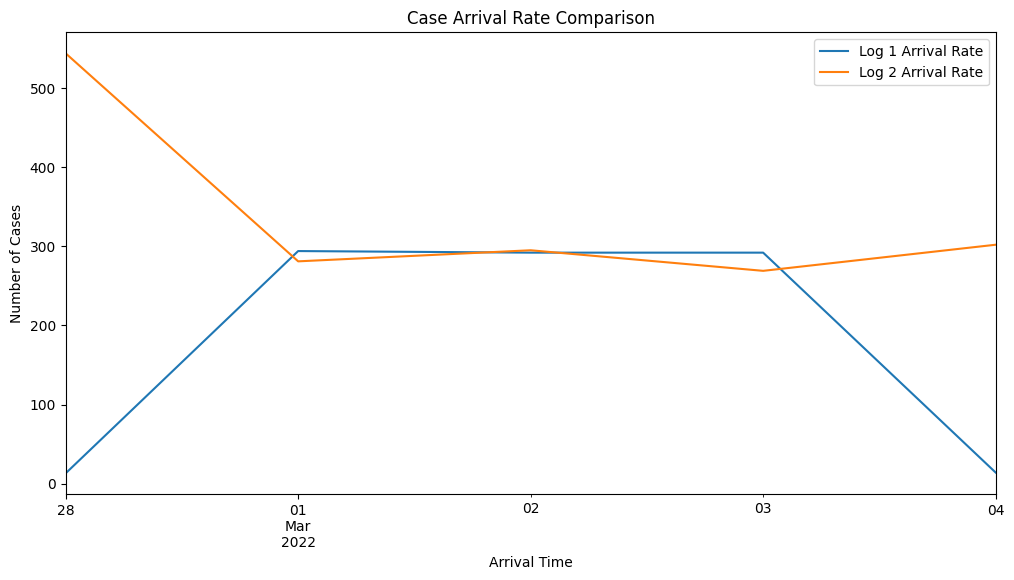

In [43]:
log1 = filtered_sdf.copy()
log2 = filtered_el.copy()

log1['time:timestamp'] = pd.to_datetime(log1['time:timestamp'])
log2['time:timestamp'] = pd.to_datetime(log2['time:timestamp'])

arrival_times_log1 = log1.groupby('case:concept:name')['time:timestamp'].min()
arrival_times_log2 = log2.groupby('case:concept:name')['time:timestamp'].min()

df_arrival_times_log1 = pd.DataFrame({'Arrival Time': arrival_times_log1})
df_arrival_times_log2 = pd.DataFrame({'Arrival Time': arrival_times_log2})

df_arrival_times_log1.set_index('Arrival Time', inplace=True)
df_arrival_times_log2.set_index('Arrival Time', inplace=True)

arrival_rate_log1 = df_arrival_times_log1.resample('D').size()
arrival_rate_log2 = df_arrival_times_log2.resample('D').size()

all_dates = arrival_rate_log1.index.union(arrival_rate_log2.index)
arrival_rate_log1 = arrival_rate_log1.reindex(all_dates, fill_value=0)
arrival_rate_log2 = arrival_rate_log2.reindex(all_dates, fill_value=0)

arrival_rate_diff = (arrival_rate_log1 - arrival_rate_log2).abs()

comparison_df = pd.DataFrame({
    'Log 1 Arrival Rate': arrival_rate_log1,
    'Log 2 Arrival Rate': arrival_rate_log2,
    'Absolute Difference': arrival_rate_diff
})

print(comparison_df)

comparison_df[['Log 1 Arrival Rate', 'Log 2 Arrival Rate']].plot(kind='line', figsize=(12, 6), title='Case Arrival Rate Comparison')
plt.ylabel('Number of Cases')
plt.show()


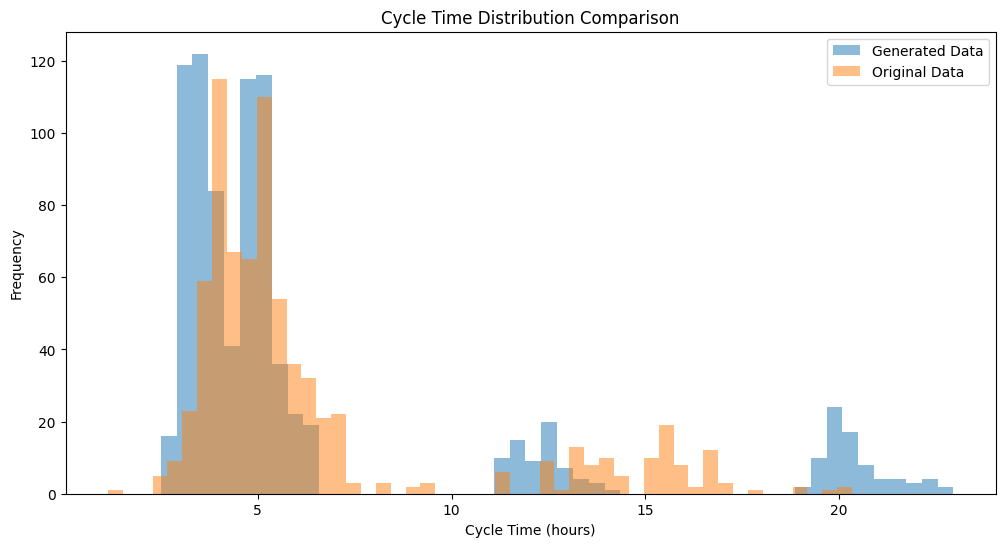

6.433217177751228
5.066362809398242
6.370148247978436
3.766234147143176


In [50]:
log1 = filtered_sdf.copy()
log2 = filtered_el.copy()

log1['time:timestamp'] = pd.to_datetime(log1['time:timestamp'])
log2['time:timestamp'] = pd.to_datetime(log2['time:timestamp'])

start_times_log1 = log1[log1['concept:name'] == 'Entrada Material Sucio'].groupby('case:concept:name')['time:timestamp'].min()
end_times_log1 = log1[log1['concept:name'] == 'Carga de esterilizador liberada'].groupby('case:concept:name')['time:timestamp'].max()

start_times_log2 = log2[log2['concept:name'] == 'Entrada Material Sucio'].groupby('case:concept:name')['time:timestamp'].min()
end_times_log2 = log2[log2['concept:name'] == 'Carga de esterilizador liberada'].groupby('case:concept:name')['time:timestamp'].max()

cycle_times_log1 = end_times_log1 - start_times_log1
cycle_times_log2 = end_times_log2 - start_times_log2

cycle_times_log1_seconds = cycle_times_log1.dt.total_seconds() / 60 / 60
cycle_times_log2_seconds = cycle_times_log2.dt.total_seconds() / 60 / 60

df_cycle_times_log1 = pd.DataFrame({'Cycle Time (seconds)': cycle_times_log1_seconds})
df_cycle_times_log2 = pd.DataFrame({'Cycle Time (seconds)': cycle_times_log2_seconds})

plt.figure(figsize=(12, 6))
plt.hist(cycle_times_log1_seconds, bins=50, alpha=0.5, label='Generated Data')
plt.hist(cycle_times_log2_seconds, bins=50, alpha=0.5, label='Original Data')
plt.xlabel('Cycle Time (hours)')
plt.ylabel('Frequency')
plt.title('Cycle Time Distribution Comparison')
plt.legend(loc='upper right')
plt.show()

print(cycle_times_log1_seconds.mean())
print(cycle_times_log1_seconds.std())
print(cycle_times_log2_seconds.mean())
print(cycle_times_log2_seconds.std())

Log 1 - Daily Statistics (Mean and Std):
         date      mean       std
0  2022-03-01  6.636491  5.151105
1  2022-03-02  6.288657  5.122572
2  2022-03-03  6.763586  5.281662
3  2022-03-04  4.302216  0.570660

Log 2 - Daily Statistics (Mean and Std):
         date      mean       std
0  2022-02-28  5.324321  2.590290
1  2022-03-01  7.272075  3.944716
2  2022-03-02  7.799889  5.247993
3  2022-03-03  6.479980  3.604955
4  2022-03-04  4.768192  0.891451


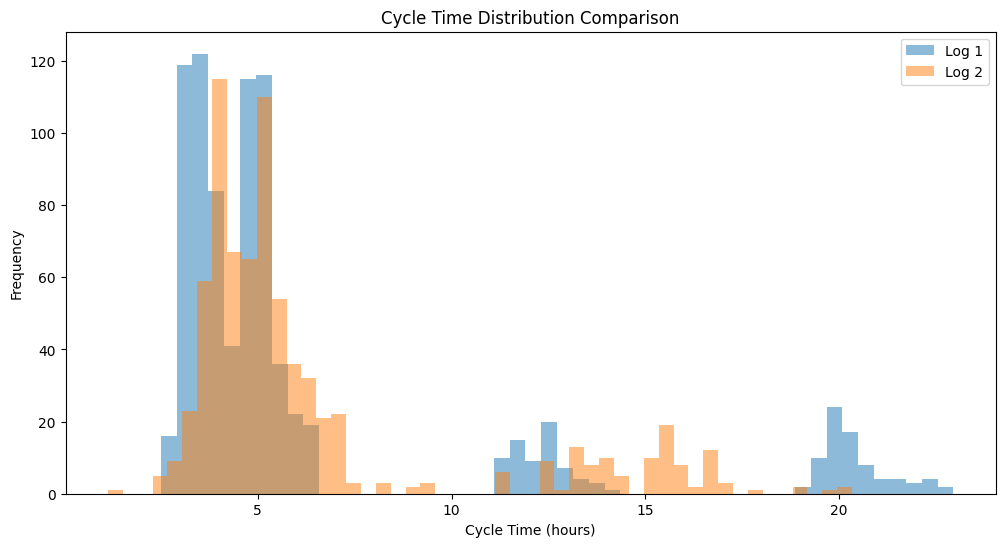

In [49]:
log1 = filtered_sdf.copy()
log2 = filtered_el.copy()

log1['time:timestamp'] = pd.to_datetime(log1['time:timestamp'])
log2['time:timestamp'] = pd.to_datetime(log2['time:timestamp'])

start_times_log1 = log1[log1['concept:name'] == 'Entrada Material Sucio'].groupby('case:concept:name')['time:timestamp'].min()
end_times_log1 = log1[log1['concept:name'] == 'Carga de esterilizador liberada'].groupby('case:concept:name')['time:timestamp'].max()

start_times_log2 = log2[log2['concept:name'] == 'Entrada Material Sucio'].groupby('case:concept:name')['time:timestamp'].min()
end_times_log2 = log2[log2['concept:name'] == 'Carga de esterilizador liberada'].groupby('case:concept:name')['time:timestamp'].max()

cycle_times_log1 = end_times_log1 - start_times_log1
cycle_times_log2 = end_times_log2 - start_times_log2

cycle_times_log1_hours = cycle_times_log1.dt.total_seconds() / 3600
cycle_times_log2_hours = cycle_times_log2.dt.total_seconds() / 3600

df_cycle_times_log1 = pd.DataFrame({'Cycle Time (hours)': cycle_times_log1_hours, 'date': start_times_log1.dt.date})
df_cycle_times_log2 = pd.DataFrame({'Cycle Time (hours)': cycle_times_log2_hours, 'date': start_times_log2.dt.date})

daily_stats_log1 = df_cycle_times_log1.groupby('date')['Cycle Time (hours)'].agg(['mean', 'std']).reset_index()
daily_stats_log2 = df_cycle_times_log2.groupby('date')['Cycle Time (hours)'].agg(['mean', 'std']).reset_index()

print("Log 1 - Daily Statistics (Mean and Std):")
print(daily_stats_log1)

print("\nLog 2 - Daily Statistics (Mean and Std):")
print(daily_stats_log2)

plt.figure(figsize=(12, 6))
plt.hist(cycle_times_log1_hours, bins=50, alpha=0.5, label='Log 1')
plt.hist(cycle_times_log2_hours, bins=50, alpha=0.5, label='Log 2')
plt.xlabel('Cycle Time (hours)')
plt.ylabel('Frequency')
plt.title('Cycle Time Distribution Comparison')
plt.legend(loc='upper right')
plt.show()

In [45]:
log2.head()

,e.Usuario,time:timestamp,concept:name,e.KitID,e.NS,e.Código,date,day_of_week,@@index,case:concept:name
16,BM,2022-03-02 21:10:00+00:00,Montaje,012047 L2901-0,0,012047 L2901,2022-03-02 00:00:00+00:00,2,13007,012047 L2901-0-CN27313
178,PN,2022-03-02 18:48:00+00:00,Cargado en carro L+D,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92707,DEP-QUI.GIN-1-CN27297
179,PN,2022-03-02 18:49:00+00:00,Carga L+D iniciada,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92704,DEP-QUI.GIN-1-CN27297
180,EH,2022-03-02 20:59:00+00:00,Carga L+D liberada,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92701,DEP-QUI.GIN-1-CN27297
181,EH,2022-03-02 21:00:00+00:00,Montaje,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92706,DEP-QUI.GIN-1-CN27297


In [46]:
log2.loc[log2['concept:name'] == ('Cargado en carro L+D'), 'new_activity'] = 'entering'
log2.loc[log2['concept:name'] == ('Entrada Material Sucio'), 'new_activity'] = 'entering'
log2.loc[log2['concept:name'] == 'Entrada Material Sucio', 'lifecycle'] = 'start'
log2.loc[log2['concept:name'] == 'Cargado en carro L+D', 'lifecycle'] = 'complete'

log2.loc[log2['concept:name'] == 'Carga L+D iniciada', 'new_activity'] = 'washing'
log2.loc[log2['concept:name'] == 'Carga L+D liberada', 'new_activity'] = 'washing'
log2.loc[log2['concept:name'] == 'Carga L+D iniciada', 'lifecycle'] = 'start'
log2.loc[log2['concept:name'] == 'Carga L+D liberada', 'lifecycle'] = 'complete'

log2.loc[log2['concept:name'] == 'Montaje', 'new_activity'] = 'assembly'
log2.loc[log2['concept:name'] == 'Producción montada', 'new_activity'] = 'assembly'
log2.loc[log2['concept:name'] == 'Montaje', 'lifecycle'] = 'start'
log2.loc[log2['concept:name'] == 'Producción montada', 'lifecycle'] = 'complete'

log2.loc[log2['concept:name'] == 'Carga de esterilizador liberada', 'new_activity'] = 'sterilizing'
log2.loc[log2['concept:name'] == 'Composición de cargas', 'new_activity'] = 'sterilizing'
log2.loc[log2['concept:name'] == 'Composición de cargas', 'lifecycle'] = 'start'
log2.loc[log2['concept:name'] == 'Carga de esterilizador liberada', 'lifecycle'] = 'complete'

log2.head()


,e.Usuario,time:timestamp,concept:name,e.KitID,e.NS,e.Código,date,day_of_week,@@index,case:concept:name,new_activity,lifecycle
16,BM,2022-03-02 21:10:00+00:00,Montaje,012047 L2901-0,0,012047 L2901,2022-03-02 00:00:00+00:00,2,13007,012047 L2901-0-CN27313,assembly,start
178,PN,2022-03-02 18:48:00+00:00,Cargado en carro L+D,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92707,DEP-QUI.GIN-1-CN27297,entering,complete
179,PN,2022-03-02 18:49:00+00:00,Carga L+D iniciada,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92704,DEP-QUI.GIN-1-CN27297,washing,start
180,EH,2022-03-02 20:59:00+00:00,Carga L+D liberada,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92701,DEP-QUI.GIN-1-CN27297,washing,complete
181,EH,2022-03-02 21:00:00+00:00,Montaje,DEP-QUI.GIN-1,1,DEP-QUI.GIN,2022-03-02 00:00:00+00:00,2,92706,DEP-QUI.GIN-1-CN27297,assembly,start


In [47]:
log1 = filtered_sdf.copy()

log1.loc[log1['concept:name'] == ('Cargado en carro L+D'), 'new_activity'] = 'entering'
log1.loc[log1['concept:name'] == ('Entrada Material Sucio'), 'new_activity'] = 'entering'
log1.loc[log1['concept:name'] == 'Entrada Material Sucio', 'lifecycle'] = 'start'
log1.loc[log1['concept:name'] == 'Cargado en carro L+D', 'lifecycle'] = 'complete'

log1.loc[log1['concept:name'] == 'Carga L+D iniciada', 'new_activity'] = 'washing'
log1.loc[log1['concept:name'] == 'Carga L+D liberada', 'new_activity'] = 'washing'
log1.loc[log1['concept:name'] == 'Carga L+D iniciada', 'lifecycle'] = 'start'
log1.loc[log1['concept:name'] == 'Carga L+D liberada', 'lifecycle'] = 'complete'

log1.loc[log1['concept:name'] == 'start assembly', 'new_activity'] = 'assembly'
log1.loc[log1['concept:name'] == 'finish assembly', 'new_activity'] = 'assembly'
log1.loc[log1['concept:name'] == 'start assembly', 'lifecycle'] = 'start'
log1.loc[log1['concept:name'] == 'finish assembly', 'lifecycle'] = 'complete'

log1.loc[log1['concept:name'] == 'Carga de esterilizador liberada', 'new_activity'] = 'sterilizing'
log1.loc[log1['concept:name'] == 'Composición de cargas', 'new_activity'] = 'sterilizing'
log1.loc[log1['concept:name'] == 'Composición de cargas', 'lifecycle'] = 'start'
log1.loc[log1['concept:name'] == 'Carga de esterilizador liberada', 'lifecycle'] = 'complete'

log1 = log1[log1['new_activity'].notnull()]
log1 = log1[log1['lifecycle:transition'] == 'start']
log1.head(10)


,concept:name,lifecycle:transition,time:timestamp,case:concept:name,org:resource,date,new_activity,lifecycle
2,Entrada Material Sucio,start,2022-03-01 06:00:00+00:00,1,Usuario_CLE,2022-03-01,entering,start
4,Cargado en carro L+D,start,2022-03-01 06:33:48+00:00,1,Usuario_CLE,2022-03-01,entering,complete
6,Carga L+D iniciada,start,2022-03-01 06:41:49+00:00,1,Usuario_CLE,2022-03-01,washing,start
10,Carga L+D liberada,start,2022-03-01 07:44:23+00:00,1,Usuario_CLE,2022-03-01,washing,complete
13,start assembly,start,2022-03-01 08:08:23+00:00,1,NaN,2022-03-01,assembly,start
31,finish assembly,start,2022-03-01 08:08:23+00:00,1,NaN,2022-03-01,assembly,complete
34,Composición de cargas,start,2022-03-01 08:16:02+00:00,1,Usuario_CLE,2022-03-01,sterilizing,start
36,Composición de cargas,start,2022-03-01 08:16:02+00:00,1,Usuario_CLE,2022-03-01,sterilizing,start
38,Composición de cargas,start,2022-03-01 08:16:02+00:00,1,Usuario_CLE,2022-03-01,sterilizing,start
40,Composición de cargas,start,2022-03-01 08:16:02+00:00,1,Usuario_CLE,2022-03-01,sterilizing,start


             Mean Duration (minutes)_Log1  Std Duration (minutes)_Log1  \
entering                        34.075378                   133.029529   
washing                        135.422689                   139.426126   
assembly                        71.919319                   207.708794   
sterilizing                    102.955914                    96.269664   

             Mean Duration (minutes)_Log2  Std Duration (minutes)_Log2  
entering                        35.697036                   248.909115  
washing                        100.533109                   276.411690  
assembly                       122.934333                   393.989534  
sterilizing                    189.634783                   351.023011  


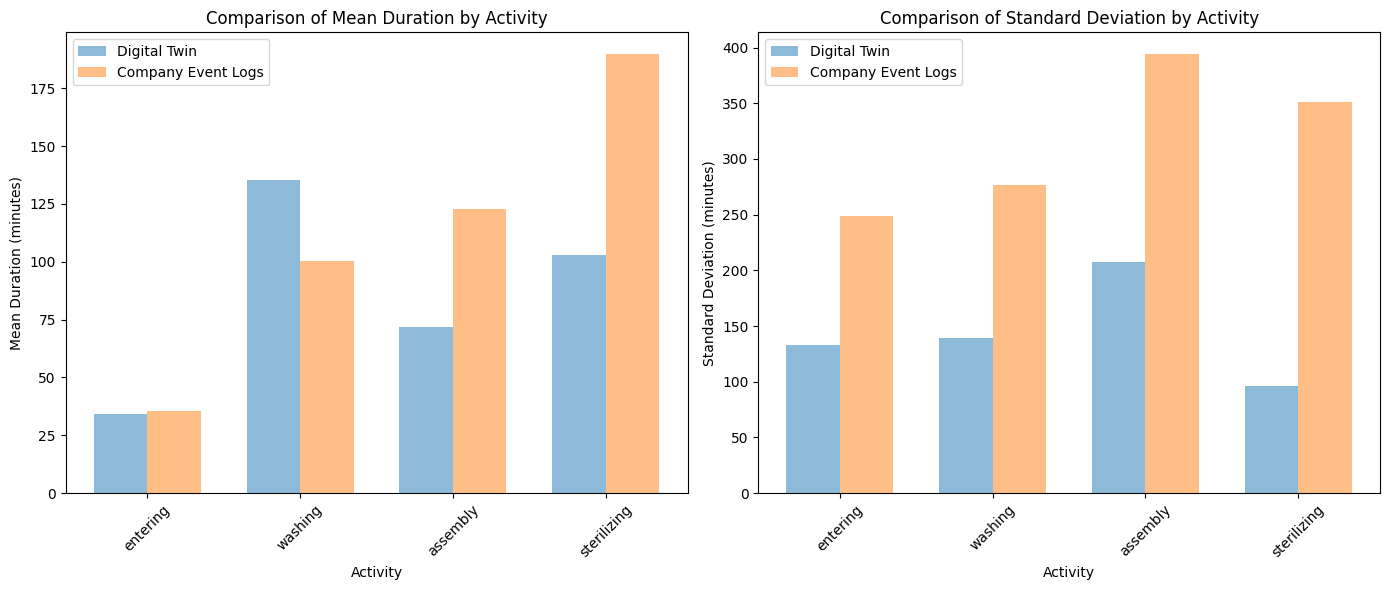

In [48]:
log1['time:timestamp'] = pd.to_datetime(log1['time:timestamp'])
log2['time:timestamp'] = pd.to_datetime(log2['time:timestamp'])

duration_stats_log1 = calculate_activity_duration_stats_mod(log1)
duration_stats_log2 = calculate_activity_duration_stats_mod(log2)

comparison_df = duration_stats_log1.join(duration_stats_log2, lsuffix='_Log1', rsuffix='_Log2')


print(comparison_df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
bar_width = 0.35
index = np.arange(len(comparison_df))

axes[0].bar(index, comparison_df['Mean Duration (minutes)_Log1'], bar_width, label='Digital Twin', alpha = 0.5)
axes[0].bar(index + bar_width, comparison_df['Mean Duration (minutes)_Log2'], bar_width, label='Company Event Logs', alpha = 0.5)
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Mean Duration (minutes)')
axes[0].set_title('Comparison of Mean Duration by Activity')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(comparison_df.index, rotation=45)
axes[0].legend()

axes[1].bar(index, comparison_df['Std Duration (minutes)_Log1'], bar_width, label='Digital Twin', alpha = 0.5)
axes[1].bar(index + bar_width, comparison_df['Std Duration (minutes)_Log2'], bar_width, label='Company Event Logs', alpha = 0.5)
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Standard Deviation (minutes)')
axes[1].set_title('Comparison of Standard Deviation by Activity')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(comparison_df.index, rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()


Mean Duration (seconds)_Log1  Std Duration (seconds)_Log1  \
entering                        49.565556                   173.202293   
washing                        155.508333                   270.704369   
assembly                         2.445000                     2.593441   
sterilizing                    187.860833                   291.207345   

             Mean Duration (seconds)_Log2  Std Duration (seconds)_Log2  
entering                        66.250000                   263.946357  
washing                        109.125000                   357.378646  
assembly                        51.184783                   262.274495  
sterilizing                    130.346939                   305.604087  

newest 
             Mean Duration (seconds)_Log1  Std Duration (seconds)_Log1  \
entering                        42.249621                   146.531358   
washing                         96.587121                    55.279526   
assembly                         0.000000                     0.000000   
sterilizing                    121.894318                   148.396551   

             Mean Duration (seconds)_Log2  Std Duration (seconds)_Log2  
entering                        31.850515                   123.414812  
washing                         86.728205                   266.868269  
assembly                        48.307910                   286.479359  
sterilizing                    137.342711                   334.116846  

newest3
            Mean Duration (seconds)_Log1  Std Duration (seconds)_Log1  \
entering                        69.478611                   218.667993   
washing                        135.193611                   202.216256   
assembly                         0.000000                     0.000000   
sterilizing                    196.271944                   336.276480   

             Mean Duration (seconds)_Log2  Std Duration (seconds)_Log2  
entering                        66.250000                   263.946357  
washing                        109.125000                   357.378646  
assembly                        51.184783                   262.274495  
sterilizing                    130.346939                   305.604087 